In [22]:
# Importing all packages
import shutil
import cv2
import os
import sys
# module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
# if module_path not in sys.path:
#     sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.applications import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Activation, Input
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings("ignore")

from keras import layers
from keras import models
from keras import optimizers

from sklearn.utils.class_weight import compute_class_weight
import joblib
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random

In [2]:
# Connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Directing Google drive to Colab_Notebooks folder
%cd /content/drive/MyDrive/Colab_Notebooks/

/content/drive/MyDrive/Colab_Notebooks


In [ ]:
# Direct Google drive to the Images folder in the Colab_Notebook folder
base = '/content/drive/MyDrive/Colab_Notebooks/Images/'
# Creating subdirectories (young_age, middle_age, old_age) within the base folder
young_age_dir = os.path.join(base, 'young_age')
middle_age_dir = os.path.join(base, 'middle_age')
old_age_dir = os.path.join(base, 'old_age')
# Setting the age limit for each class
young_age_threshold = 30
old_age_threshold = 60
# Creating young, middle, and old age folders if it is not created
if not os.path.exists(young_age_dir):
  os.makedirs(young_age_dir)
if not os.path.exists(middle_age_dir):
  os.makedirs(middle_age_dir)
if not os.path.exists(old_age_dir):
  os.makedirs(old_age_dir)
# Moving the .jpg files to the appropriate age group
# young_age is between 0-29, middle_age is between 30-59, old_age is from 60-90+
for filename in os.listdir(base):
  if filename.endswith('.jpg'):
    age = int(filename.split('_')[0])
    if age < young_age_threshold:
      shutil.move(os.path.join(base, filename), os.path.join(young_age_dir, filename))
    elif age < old_age_threshold:
      shutil.move(os.path.join(base, filename), os.path.join(middle_age_dir, filename))
    else:
      shutil.move(os.path.join(base, filename), os.path.join(old_age_dir, filename))

In [ ]:
# Renaming the files with the age class in front of the file name (young_, middle_, old_)
for filename in os.listdir(young_age_dir):
  if filename.endswith('.jpg'):
    os.rename(os.path.join(young_age_dir, filename), os.path.join(young_age_dir, 'young_' + filename))

for filename in os.listdir(middle_age_dir):
  if filename.endswith('.jpg'):
    os.rename(os.path.join(middle_age_dir, filename), os.path.join(middle_age_dir, 'middle_' + filename))

for filename in os.listdir(old_age_dir):
  if filename.endswith('.jpg'):
    os.rename(os.path.join(old_age_dir, filename), os.path.join(old_age_dir, 'old_' + filename))

In [ ]:
# Creating a path to the Images folder
path_to_folder = '/content/drive/MyDrive/Colab_Notebooks/Images'
# Moving the subfolders into the Images folder
young_age_dir = os.path.join(path_to_folder, 'young_age')
middle_age_dir = os.path.join(path_to_folder, 'middle_age')
old_age_dir = os.path.join(path_to_folder, 'old_age')
# Creating the classes for the age column of the data frame
categories = ['young_age', 'middle_age', 'old_age']
# Creating a data frame with the filename as the ID and age as the classes
data = []

for category in categories:
    folder_path = os.path.join(path_to_folder, category)
    for filename in os.listdir(folder_path):
        new_filename = category.split('_')[0] + '_' + '_'.join(filename.split('_')[1:])
        data.append([new_filename, category])

df = pd.DataFrame(data, columns=['filename', 'age'])
df

,filename,age
0,young_22_0_0_20170104214301269.jpg,young_age
1,young_28_0_3_20170104215712759.jpg,young_age
2,young_28_0_3_20170104220743173.jpg,young_age
3,young_27_1_3_20170104223405095.jpg,young_age
4,young_10_1_3_20170104221633430.jpg,young_age
...,...,...
4026,old_65_0_0_20170111195233409.jpg,old_age
4027,old_65_0_0_20170111195430569.jpg,old_age
4028,old_72_0_0_20170111195358992.jpg,old_age
4029,old_65_0_0_20170111195412945.jpg,old_age


In [ ]:
# Saving the DataFrame as pickle file
df.to_pickle('Age.pkl')

In [ ]:
# Looking at the amount of pictures in each class folder
print(len(os.listdir(young_age_dir)))
print(len(os.listdir(middle_age_dir)))
print(len(os.listdir(old_age_dir)))

1360
1407
1264


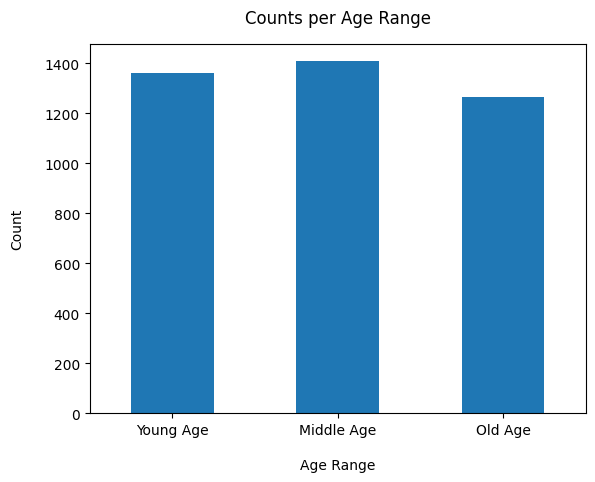

In [ ]:
# Looking at the distribution of pictures for each class subfolder
# The classes seem balanced
category_counts = df['age'].value_counts()
category_counts = category_counts.reindex(['young_age', 'middle_age', 'old_age'])
category_counts.plot.bar()
labels = ['Young Age', 'Middle Age', 'Old Age']
plt.gca().set_xticklabels(labels, rotation=0)
plt.xlabel('Age Range', labelpad=15)
plt.ylabel('Count', labelpad=15)
plt.title('Counts per Age Range', pad=15);

In [ ]:
# Doing a train test validation split with all the images and making the train, test, val folder with the class subfolders in each of the folders

# Test folder
source_dir_young = '/content/drive/MyDrive/Colab_Notebooks/Images/young_age'
test_dest_dir_young = '/content/drive/MyDrive/Colab_Notebooks/Images/Test/young_age'

if not os.path.exists(test_dest_dir_young):
  os.makedirs(test_dest_dir_young)

file_list1 = [f for f in os.listdir(source_dir_young) if f.endswith('.jpg')]

num_files1 = int(len(file_list1) * 0.1)

files_to_move1 = random.sample(file_list1, num_files1)

for file in files_to_move1:
  src_file_1 = os.path.join(source_dir_young, file)
  dest_file_1 = os.path.join(test_dest_dir_young, file)
  shutil.move(src_file_1, dest_file_1)


source_dir_middle = '/content/drive/MyDrive/Colab_Notebooks/Images/middle_age'
test_dest_dir_middle = '/content/drive/MyDrive/Colab_Notebooks/Images/Test/middle_age'

if not os.path.exists(test_dest_dir_middle):
  os.makedirs(test_dest_dir_middle)

file_list2 = [f for f in os.listdir(source_dir_middle) if f.endswith('.jpg')]

num_files2 = int(len(file_list2) * 0.1)

files_to_move2 = random.sample(file_list2, num_files2)

for file in files_to_move2:
  src_file_2 = os.path.join(source_dir_middle, file)
  dest_file_2 = os.path.join(test_dest_dir_middle, file)
  shutil.move(src_file_2, dest_file_2)

source_dir_old = '/content/drive/MyDrive/Colab_Notebooks/Images/old_age'
test_dest_dir_old = '/content/drive/MyDrive/Colab_Notebooks/Images/Test/old_age'

if not os.path.exists(test_dest_dir_old):
  os.makedirs(test_dest_dir_old)

file_list3 = [f for f in os.listdir(source_dir_old) if f.endswith('.jpg')]

num_files3 = int(len(file_list3) * 0.1)

files_to_move3 = random.sample(file_list3, num_files3)

for file in files_to_move3:
  src_file_3 = os.path.join(source_dir_old, file)
  dest_file_3 = os.path.join(test_dest_dir_old, file)
  shutil.move(src_file_3, dest_file_3)

# Train folder
train_dest_dir_old = '/content/drive/MyDrive/Colab_Notebooks/Images/Train/old_age'

if not os.path.exists(train_dest_dir_old):
  os.makedirs(train_dest_dir_old)

file_list4 = [f for f in os.listdir(source_dir_old) if f.endswith('.jpg')]

num_files4 = int(len(file_list4) * 1)

files_to_move4 = random.sample(file_list4, num_files4)

for file in files_to_move4:
  src_file_4 = os.path.join(source_dir_old, file)
  dest_file_4 = os.path.join(train_dest_dir_old, file)
  shutil.move(src_file_4, dest_file_4)


train_dest_dir_middle = '/content/drive/MyDrive/Colab_Notebooks/Images/Train/middle_age'

if not os.path.exists(train_dest_dir_middle):
  os.makedirs(train_dest_dir_middle)

file_list5 = [f for f in os.listdir(source_dir_middle) if f.endswith('.jpg')]

num_files5 = int(len(file_list5) * 1)

files_to_move5 = random.sample(file_list5, num_files5)

for file in files_to_move5:
  src_file_5 = os.path.join(source_dir_middle, file)
  dest_file_5 = os.path.join(train_dest_dir_middle, file)
  shutil.move(src_file_5, dest_file_5)


train_dest_dir_young = '/content/drive/MyDrive/Colab_Notebooks/Images/Train/young_age'

if not os.path.exists(train_dest_dir_young):
  os.makedirs(train_dest_dir_young)

file_list6 = [f for f in os.listdir(source_dir_young) if f.endswith('.jpg')]

num_files6 = int(len(file_list6) * 0.1)

files_to_move6 = random.sample(file_list6, num_files6)

for file in files_to_move6:
  src_file_6 = os.path.join(source_dir_young, file)
  dest_file_6 = os.path.join(train_dest_dir_young, file)
  shutil.move(src_file_6, dest_file_6)

#Validation Folder

# Splitting from the train folder for the validation folder
train_source_dir_old = '/content/drive/MyDrive/Colab_Notebooks/Images/Train/old_age'
train_source_dir_middle = '/content/drive/MyDrive/Colab_Notebooks/Images/Train/middle_age'
train_source_dir_young = '/content/drive/MyDrive/Colab_Notebooks/Images/Train/young_age'

val_dest_dir_old = '/content/drive/MyDrive/Colab_Notebooks/Images/Val/old_age'

if not os.path.exists(val_dest_dir_old):
  os.makedirs(val_dest_dir_old)

file_list7 = [f for f in os.listdir(train_source_dir_old) if f.endswith('.jpg')]

num_files7 = int(len(file_list7) * 0.1)

files_to_move7 = random.sample(file_list7, num_files7)

for file in files_to_move7:
  src_file_7 = os.path.join(train_source_dir_old, file)
  dest_file_7 = os.path.join(val_dest_dir_old, file)
  shutil.move(src_file_7, dest_file_7)


val_dest_dir_middle = '/content/drive/MyDrive/Colab_Notebooks/Images/Val/middle_age'

if not os.path.exists(val_dest_dir_middle):
  os.makedirs(val_dest_dir_middle)

file_list8 = [f for f in os.listdir(train_source_dir_middle) if f.endswith('.jpg')]

num_files8 = int(len(file_list8) * 0.1)

files_to_move8 = random.sample(file_list8, num_files8)

for file in files_to_move8:
  src_file_8 = os.path.join(train_source_dir_middle, file)
  dest_file_8 = os.path.join(val_dest_dir_middle, file)
  shutil.move(src_file_8, dest_file_8)


val_dest_dir_young = '/content/drive/MyDrive/Colab_Notebooks/Images/Val/young_age'

if not os.path.exists(val_dest_dir_young):
  os.makedirs(val_dest_dir_young)

file_list9 = [f for f in os.listdir(train_source_dir_young) if f.endswith('.jpg')]

num_files9 = int(len(file_list9) * 0.1)

files_to_move9 = random.sample(file_list9, num_files9)

for file in files_to_move9:
  src_file_9 = os.path.join(train_source_dir_young, file)
  dest_file_9 = os.path.join(val_dest_dir_young, file)
  shutil.move(src_file_9, dest_file_9)

In [4]:
# Creating directories for the train, test, and validation folders
train_dir = '/content/drive/MyDrive/Colab_Notebooks/Images/Train'
test_dir = '/content/drive/MyDrive/Colab_Notebooks/Images/Test'
val_dir = '/content/drive/MyDrive/Colab_Notebooks/Images/Val'

In [ ]:
# Printing out DataFrame
df

,filename,age
0,young_22_0_0_20170104214301269.jpg,young_age
1,young_28_0_3_20170104215712759.jpg,young_age
2,young_28_0_3_20170104220743173.jpg,young_age
3,young_27_1_3_20170104223405095.jpg,young_age
4,young_10_1_3_20170104221633430.jpg,young_age
...,...,...
4026,old_65_0_0_20170111195233409.jpg,old_age
4027,old_65_0_0_20170111195430569.jpg,old_age
4028,old_72_0_0_20170111195358992.jpg,old_age
4029,old_65_0_0_20170111195412945.jpg,old_age


In [5]:
# Creating image data generators for training, validation, and testing sets
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    shuffle=True)

validation_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    shuffle=False)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    shuffle=False)

Found 3268 images belonging to 3 classes.
Found 361 images belonging to 3 classes.
Found 402 images belonging to 3 classes.


In [6]:
# Printing the class indices, but the classes are out of order
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'middle_age': 0, 'old_age': 1, 'young_age': 2}
{'middle_age': 0, 'old_age': 1, 'young_age': 2}
{'middle_age': 0, 'old_age': 1, 'young_age': 2}


In [7]:
# Fixing the order of the class indices
new_class_indices = {'young_age': 0, 'middle_age': 1, 'old_age': 2}

train_generator.class_indices = new_class_indices
test_generator.class_indices = new_class_indices
validation_generator.class_indices = new_class_indices

print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'young_age': 0, 'middle_age': 1, 'old_age': 2}
{'young_age': 0, 'middle_age': 1, 'old_age': 2}
{'young_age': 0, 'middle_age': 1, 'old_age': 2}


In [8]:
# Baseline model
# Defining the architecture of the model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [9]:
# Compiling the model and getting the summary
model.compile(loss='categorical_crossentropy',
              optimizer= 'adam',
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [10]:
# Creating early stopping by looking at the validation accuracy and stopping if the accuracy does not change by .01 for 5 epochs
early_stop = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=5)
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs= 3000,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/3000
52/52 [==============================] - 1550s 30s/step - loss: 1.1128 - acc: 0.3984 - val_loss: 1.0143 - val_acc: 0.5125
Epoch 2/3000
52/52 [==============================] - 123s 2s/step - loss: 0.9963 - acc: 0.5193 - val_loss: 0.9591 - val_acc: 0.5706
Epoch 3/3000
52/52 [==============================] - 108s 2s/step - loss: 0.9306 - acc: 0.5661 - val_loss: 0.9451 - val_acc: 0.5900
Epoch 4/3000
52/52 [==============================] - 106s 2s/step - loss: 0.8740 - acc: 0.5976 - val_loss: 0.9135 - val_acc: 0.5789
Epoch 5/3000
52/52 [==============================] - 106s 2s/step - loss: 0.8000 - acc: 0.6509 - val_loss: 0.9378 - val_acc: 0.5900
Epoch 6/3000
52/52 [==============================] - 126s 2s/step - loss: 0.7273 - acc: 0.6775 - val_loss: 0.9024 - val_acc: 0.6288
Epoch 7/3000
52/52 [==============================] - 145s 3s/step - loss: 0.6453 - acc: 0.7218 - val_loss: 1.0051 - val_acc: 0.5900
Epoch 8/3000
52/52 [==============================] - 133s 3s/step 

In [12]:
# Evaluating the model on the test set
test_x, test_y = next(test_generator)
test_results = model.evaluate(test_x, test_y)

2/2 [==============================] - 0s 216ms/step - loss: 2.2474 - acc: 0.4688


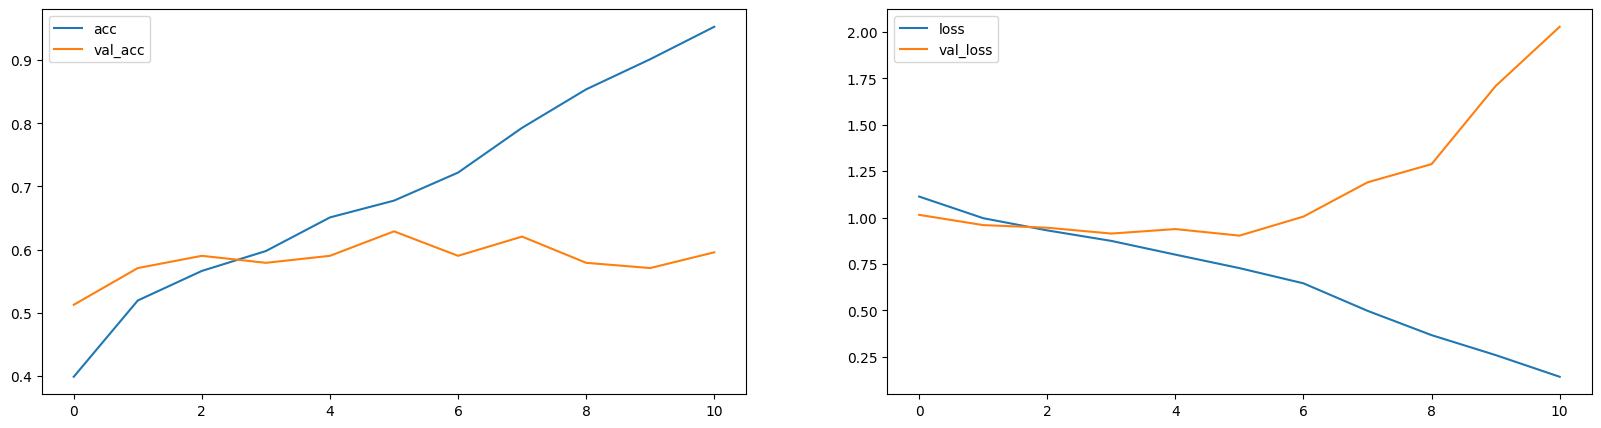

In [14]:
# Creating ROC Curve for the accuracy and the loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label= 'loss')
plt.plot(history.history['val_loss'], label= 'val_loss')
plt.legend();

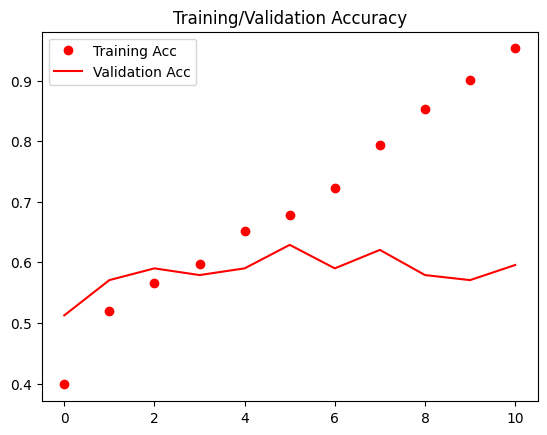

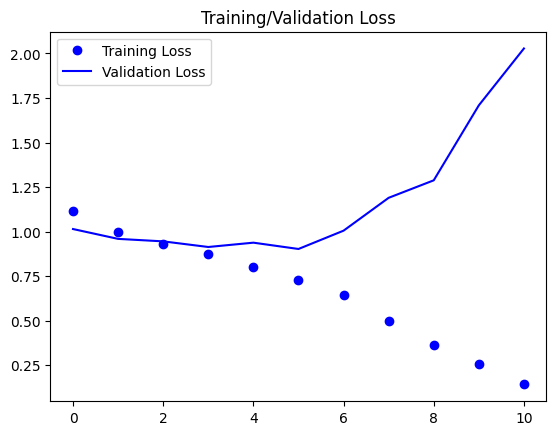

In [15]:
# Plotting if the model predicts well against validation data
# Seems like the model is not predicting well
epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training Acc')
plt.plot(epochs, val_acc, 'r', label='Validation Acc')
plt.title('Training/Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training/Validation Loss')
plt.legend();

In [16]:
# Saving the baseline model
model.save('Baseline_CNN_Age_model')

6/6 [==============================] - 5s 861ms/step


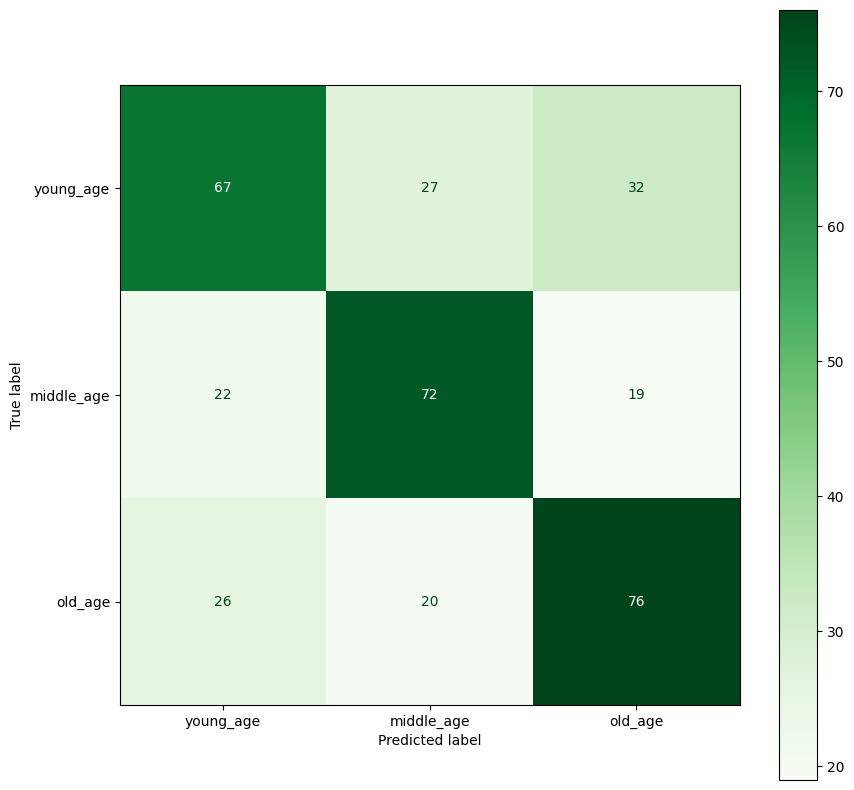

In [18]:
# Creating a confusion matrix to see how will the model predicts for each class
predict_probs = model.predict(validation_generator)

predict_labels = np.argmax(predict_probs, axis=1)

true_labels = validation_generator.classes

cm = confusion_matrix(true_labels, predict_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Greens, ax=ax);

In [24]:
# Creating a classification report to get the precision, recall, and f1-score
class_names = list(test_generator.class_indices.keys())

class_report = classification_report(true_labels, predict_labels, target_names=class_names)
print(class_report)

              precision    recall  f1-score   support

   young_age       0.58      0.53      0.56       126
  middle_age       0.61      0.64      0.62       113
     old_age       0.60      0.62      0.61       122

    accuracy                           0.60       361
   macro avg       0.60      0.60      0.60       361
weighted avg       0.59      0.60      0.59       361

